# SPNC rundown
*This is a rundown of thoughts and ideas for the SPNC (Superparamagnetic neuromorphic computing) project*

Notation: <br>
$\beta = 1/k_BT$ <br>
$w$ is transition rate <br>
$H_K = 2K/M_s $

Some useful references: <br>
Theory of ferromagnetism, Aharoni [ISBN: 0198508093](http://books.google.com/books?vid=ISBN0198508093)

***

## A model system

First we need a model of the behaviour of a superparamagnetic ensemble.
If this shows non-linearity and memory, it can be interfaced into a machine learning code. <br>
([1](http://dx.doi.org/10.1063/1.3477956)) Chantrell, Walmsley, Gore and Maylin - **Model system** for interacting superparamagnetic particles showing strong non-linearity dependant on packing density. *Many links to other papers* <br>
([2](http://dx.doi.org/10.1103/PhysRevB.63.024410)) Hovorka, Evans, Chantrell and Berger - A follow up to the above, looking at switching fields  and sweep rate dependance. <br>

From (1): <br>
We get a relaxation time/transition rate, $w = \tau^{-1} = f_0 \exp{(-E_b \beta)}$ where $f_0$ is typically taken between $10^9$ &ndash; $10^{11}$ s$^{-1}$ (strictly it is a very slowly changing variable, but this can typically be ignored)<br>
To begin with we will consider $KV \gg \beta^{-1}$ as this approximates to a simple two state system&mdash;otherwise something like the Metropolis algorith is required to take into account the local moves near the minima. We can then describe the system using the master equation for a two-state system: <br>
$$ \frac{dn_1}{dt} = \frac{n_2}{\tau_{21}} - \frac{n_1}{\tau_{12}} $$ <br>
- Given that $ n = n_1 + n_2 $ and $ M = M_s v (n_1 - n_2)$ $\implies M = Ms V (2 n_1 - n)$ <br>
- This approach works well for $ E_b \geq 3 \beta^{-1} $ <br>
Taking the field along the anisotropy axis, in direction such that state 1 is the minima for positive field and using $H_k = 2K/M_s$:
$$ E_{21} = KV( 1 - H/H_K)^2$$ and $$ E_{12} = KV( 1 + H/H_K)^2 $$
Therefore we can rewrite the master equation as:
$$ \frac{dn_1}{dt} = f_0 (n - n_1) \exp{(-\beta KV(1-H/H_k)^2)} - f_0 n_1 \exp{(-\beta KV(1+H/H_k)^2)} $$ <br>


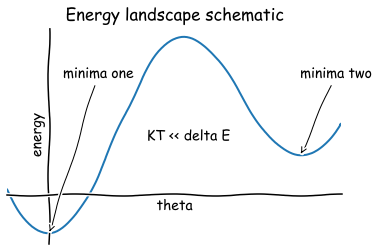

In [64]:
from matplotlib import pyplot as plt
import numpy as np

# Basic energy for 1D model with H along the anisotropy axis
def basic_energy(K,V,muH,theta):
    energy = K*V*np.power(np.sin(theta*np.pi/180),2) - muH * np.cos(theta*np.pi/180)
    return energy

# Make a schematic plot for the energy
with plt.xkcd():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    plt.xticks([])
    plt.yticks([])
    plt.title('Energy landscape schematic')

    theta = np.arange(-30,210,1)
    ax.set_xlim([-30, 210])
    plt.plot(theta,basic_energy(1,1,0.25,theta))

    ax.annotate('minima one',xy=(0,basic_energy(1,1,0.25,0)),arrowprops=dict(arrowstyle='->'),xytext=(10,.75))
    ax.annotate('minima two',xy=(180,basic_energy(1,1,0.25,180)),arrowprops=dict(arrowstyle='->'),xytext=(180,.75))
    ax.annotate('KT << delta E',xy=(0,basic_energy(1,1,0.25,180)),xytext=(70,.35))

    plt.xlabel('theta')
    plt.ylabel('energy')

## Comparison to mumax model so far

![basic-system-schematic.PNG](images/basic-system-schematic.PNG)

### Tom's model

From intuition, the form under constant field/decay should be given by:

**Decay:**
$$ \frac{M}{M_s} = e^{-t/\tau} $$
**Excitation:**
$$ \frac{M}{M_s} = a(H)\left( 1 - e^{-t/b(H)} \right) $$

### The new description

***NB: I have had to change the order of ij relative to the papers, as there was a mistake!*** <br>
From (2) and (1) we can recast the master equation given above, via integration, to find the probability of occupation of either state at a time t (given constant H):
$$ p_i(t) =  \frac{w_{ji}}{w} + \left[p_i(0) - \frac{w_{ji}}{w} \right] \exp{(-wt)} $$
where $w = w_{12} + w_{21}$. As $ m = M/M_s n V = (P_1 - P_2) $ we get:
$$ m(t) = \left( \frac{w_{21} - w_{12}}{w} \right) + \left[ m(0) - \left( \frac{w_{21} - w_{12}}{w} \right) \right] \exp{(-wt)} $$
For $w_{12} = w_{21}$ (i.e. no field), this reduces to the decay term:
$$ m(t) = m(0) \exp{(-wt)} $$
For constant field and m(0) = 0, this reduces to the excitation term:
$$ m(t) = \left( \frac{w_{21} - w_{12}}{w} \right) [1 - \exp{(-wt)}] $$
NB: $w$ is field dependant, so it is *different* in these two cases!! <br>
We can therefore link a(H) and b(H) to transition rates, or likewise calculate transition rates from a(H) and b(H).
$$ a(H) = n V\left( \frac{w_{21} - w_{12}}{w} \right) =  nV \frac{e^{HM_sV\beta} - e^{-HM_sV\beta}}{e^{HM_sV\beta} + e^{-HM_sV\beta}} = nV \tanh{\left( \frac{HM_sV}{K_B T} \right)} $$
$$ 1/b(H) = w = f_0 \exp{(-\beta KV(1-H/H_k)^2)} + f_0 \exp{(-\beta KV(1+H/H_k)^2)} $$
Where the derivation following the second equals signs is for the stoner-wolfarth case. <br>
This lets us feed our mumax simulations back into a solver with the equation:
$$ \frac{dn_1}{dt} = w_{21}(H,T){n_2} - w_{12}(H,T){n_1} $$ <br>

## The stoner-wolfarth model: simplifications for modelling

In the case of the SW model, it is worth simplifying the expressions by looking at relative energies and fields; the real units are not so important here, rather the behaviour.
Let us denote $w_{21} = w_+ \, \& \, w_{12} = w_-$ and rewrite the transition rates as follows:

$$ w_{\pm} = f_0 \exp{ \left( - (KV/K_B T) (1 \mp H/H_K)^2 \right) } $$

Then taking $\beta' = KV/K_BT$ and $H' = H/H_K$ and setting (without loss of generality) $f_0 = 1$, we can write:

$$ w_{\pm} = \exp{(-\beta' (1 \mp H')^2)} $$
where we see from our condition $E_b \beta \ge 3$ that at minimum $\beta' \ge 3$ and $ |H'| < 1$. The second condition is also apparent as the higher energy state will no longer be a minimum once $H > H_K$ which breaks our two state model. <br>

We see that the important features are a thermal energy like term and a field like term - although of course they are dimensionless here! We can also more generically absorb our constant $f_0$ into the time parameter to get the dimensionless, $t' = tf_0$. Taking also that $n'_1 = n_1/n \, \, \& \, \, n'_2 = n_2 /n$, allows us to write:

$$ dn'_1 / dt' =  (1-n'_1) \exp{(-\beta' (1 - H')^2)} - n'_1 \exp{(-\beta' (1 + H')^2)}  $$
For the integrated description, we find that:
$$ \frac{w_+ - w_-}{w} = \frac{e^{2\beta' H'} - e^{-2\beta' H'}}{e^{2\beta' H'} + e^{-2\beta' H'}} = \tanh{(2\beta' H')} $$
and:
$$ w = 2 \cosh{(2\beta' H')} \exp{(-\beta' (1+H'^2))} $$
Such that:
$$ m(t') = \tanh{(2\beta' H')} + [m(0) - \tanh{(2\beta' H')}] \exp{\left( - w t' \right)} $$
Which we can rearrange to:
$$ m(t') = \tanh{(2\beta' H')} \left[ 1 - \exp{\left( - w t' \right)} \right] + m(0) \exp{\left( - w t' \right)} $$

We have two terms, an exciation and a decay, both with the same characteristic time scale. The decay represents loss of memory of the start state. The excitation represents response to the new input. Note, however, that for changing fields, the excitation to a value under one field and the decay away from it at another *do not* have the same time scale.

### An alternative viewpoint: anisotropy control

Above, we considered manipulating the system via an effective temperature and field. However, these may not, in general, be the parameters we wish to change. If we envisage a fixed (non-zero) field and a changeable anisotropy (e.g. via strain) we can condsider whether it is possible to manipulate $m(t')$. Let us consider first turning on the field. For the next time step then, $m(0) = {(w_+ - w_-)}/{w}$. In our standard case, this is independant of anisotropy - $\tanh{(HM_s V/K_B T)}$. We can examine this more closely by writing:  <br>
$$ \frac{w_+ - w_-}{w} = \frac{ f_0 \exp{(-E_+ \beta)} - f_0 \exp{(-E_- \beta)} }{ f_0 \exp{(-E_+ \beta)} + f_0 \exp{(-E_- \beta)} } $$
Adjusting the anisotropy is akin to $ E_- \rightarrow E_- + \Delta E \, \, \&  \,\, E_+ \rightarrow E_+ + \Delta E$. 
$$ \implies \frac{w_+ - w_-}{w} \rightarrow \frac{ \left[ f_0 \exp{(-E_+ \beta)} - f_0 \exp{(-E_- \beta)} \right] \exp{(-\Delta E \beta)}  }{ \left[ f_0 \exp{(-E_+ \beta)} + f_0 \exp{(-E_- \beta)} \right] \exp{(-\Delta E \beta)} } = \frac{w_+ - w_-}{w} $$

What we need to achieve is the two energies changing *differently*. One way to do that, is by rotating the anisotropy away from the field&mdash;for example with a non-colinear strain. This is easily shown with a demonstration: